In [33]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [34]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)  # 17379 * 17 variables

In [35]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days in the data set. You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

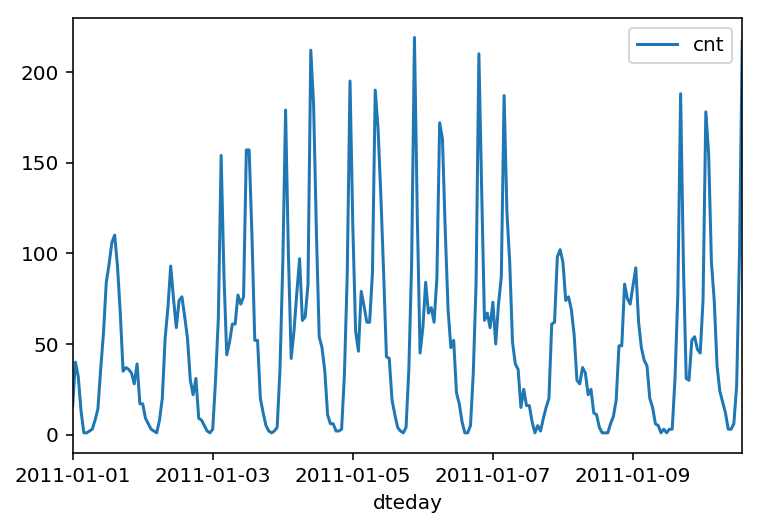

In [36]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [37]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday'] # discrete values
for each in dummy_fields:
    #Convert categorical variable into dummy/indicator variables
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False) # prefix: season_i, hr_i
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed'] 

### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [38]:
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the last 21 days of the data to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [39]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']  # targets trying to predict
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

The network has **multiple** layers, 1 input layer, (n-2) hidden layer and an output layer. The hidden layers will use the sigmoid function for activations. The output layer has only one node and is used for the regression, **the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$.** A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.

In [40]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, output_nodes, learning_rate):
        np.random.seed(1)
        self.num_layers = 2  # one layer of inputs, one layer of outputs
        self.layer_nodes_list = [input_nodes, output_nodes]
        self.layers_nodes = {1: input_nodes, 2: output_nodes}  # Set inital number of layers (input layer & output layer)
        self.weights = {1: np.random.normal(0.0, input_nodes**-0.5, (input_nodes, output_nodes))}   # Create dict to hold weights
        self.lr = learning_rate
        
    def add_layer(self,new_layer_nodes):
        self.num_layers += 1
        # Insert the hidden layers
        self.layer_nodes_list.insert(-1, new_layer_nodes) # insert the layer in the last second place
        self.layers_nodes = dict(zip(range(1,self.num_layers+1), self.layer_nodes_list))
        # Update the weights
        for i in range(1,self.num_layers): # total self.num_layers -1 weights
            self.weights[i] = np.random.normal(0.0, self.layers_nodes[i+1]**-0.5, (self.layers_nodes[i], self.layers_nodes[i+1]))
    
    def _sigmoid(self, x):
        # Activation function is the sigmoid function
        return 1.0/(1.0+ np.exp(-x))
    
    
    def _sigmoid_derivative(self,x):
        # Derivative of sigmoid function
        return x * (1.0 - x)
        
    def train(self, inputs_list, targets_list):
        # Convert input array (I,) to 2d array
        inputs = np.array(inputs_list, ndmin=2)  #  1 * I array, I: input_nodes
        targets = np.array(targets_list, ndmin=2) #  1 *K array , K: output_nodes
        
        ################################################################################
        #  Forward pass
        #  Hidden layers
        hidden_inputs = {}
        hidden_outputs = {}
        if self.num_layers>2:
            hidden_inputs[1] = np.dot(inputs, self.weights[1]) # 1*J1, first hidden layer:1
            hidden_outputs[1] = self._sigmoid(hidden_inputs[1])  # 1*J1
            for i in range(2,self.num_layers-1): # i=2,3,...., num_layers-2; extra hidden layer index
                hidden_inputs[i] = np.dot(hidden_outputs[i-1], self.weights[i])
                hidden_outputs[i] = self._sigmoid(hidden_inputs[i])   # activate function
        # Output layers
            final_inputs = np.dot(hidden_outputs[self.num_layers-2], self.weights[self.num_layers-1])  # 1*K, K:output nodes
#             final_outputs = self._sigmoid(final_inputs)       # 1*K
            final_outputs = final_inputs
        else:
        # Output layers
            final_inputs = np.dot(inputs, self.weights[1])    # 1*K, K:output nodes
#            final_outputs = self._sigmoid(final_inputs) # 1*K, K:output nodes
            final_outputs = final_inputs
        ################################################################################
        #  Backward propagation
        #  Output error: difference between desired target and actual output.
        output_errors = targets - final_outputs  # 1*K
        
        # Error gradient in the output unit
        # output_grad = self._sigmoid_derivative(final_outputs)  # 1*K
        output_grad = np.ones((1, output_nodes))  # 1*K
        # Backpropagated error
        hidden_errors = {}
        hidden_grad = {}
        if self.num_layers>2:
#             self.weights[self.num_layers-1] += self.lr * np.dot(hidden_outputs[self.num_layers-2].T, 
#                                                                 output_errors*output_grad) 
            self.weights[self.num_layers-1] += self.lr * np.dot(hidden_outputs[self.num_layers-2].T, 
                                                                output_errors) 
            hidden_errors[self.num_layers-2] = np.dot(output_errors, self.weights[self.num_layers-1].T) # 1*J(i)
            hidden_grad[self.num_layers-2] = self._sigmoid_derivative(hidden_outputs[self.num_layers-2])      # 1* J(i)
            for i in reversed(range(1, self.num_layers-2)): # i=num_layer-3, ..,1
                hidden_errors[i] = np.dot(hidden_errors[i+1], self.weights[i+1].T)  # 1*J(i-1)
                hidden_grad[i] = self._sigmoid_derivative(hidden_outputs[i])   # 1*J(i-1)
                self.weights[i+1] += self.lr * np.dot(hidden_outputs[i].T, hidden_errors[i+1]*hidden_grad[i+1]) # J(i-2)*J(i-1) 
            # i = 1
            self.weights[1] += self.lr * np.dot(inputs.T, hidden_errors[1]*hidden_grad[1]) # I*J(1)
        else:
            # error*f'(output) 
            self.weights[1] += self.lr *np.dot(inputs.T, output_errors*self._sigmoid_derivative(targets)) # I * K
    
    def run(self, input_list):
        # Run a foward pass through the network
        inputs = np.array(input_list, ndmin=2)  # N*I array
        
        
        # Implement the forward pass
        hidden_inputs = {}
        hidden_outputs = {}
        if self.num_layers>2:
            hidden_inputs[1] = np.dot(inputs, self.weights[1]) # N*J1, first hidden layer:1
            hidden_outputs[1] = self._sigmoid(hidden_inputs[1])  # N*J1
            for i in range(2,self.num_layers-1): # i=2,3,...., num_layers-2; extra hidden layer index
                hidden_inputs[i] = np.dot(hidden_outputs[i-1], self.weights[i])
                hidden_outputs[i] = self._sigmoid(hidden_inputs[i])   # activate function
        # Output layers
            final_inputs = np.dot(hidden_outputs[self.num_layers-2], self.weights[self.num_layers-1])  # N*K, K:output nodes
#             final_outputs = self._sigmoid(final_inputs)       # N*K
            final_outputs = final_inputs    
        else:
        # Output layers
            final_inputs = np.dot(inputs, self.weights[1])    # N*K, K:output nodes
#             final_outputs = self._sigmoid(final_inputs) # N*K, K:output nodes
            final_outputs = final_inputs
        return final_outputs

In [42]:
def MSE(y, Y):
    # Be careful, if y: 5*1, Y: (5,), y-Y is a 2*2 matrix instead of an array!
    if y.shape == Y.shape:
        return np.mean((y-Y)**2)
    else:
        return np.mean((y.ravel()-Y.ravel())**2) # convert to (n,)array

In [43]:
import sys
% pdb
### Set the hyperparameters here ###
epochs = 1000
learning_rate = 0.01
hidden_nodes1 = 3
hidden_nodes2 = 4
hidden_nodes3 = 5
output_nodes = 1
input_nodes = train_features.shape[1]
network = NeuralNetwork(input_nodes, output_nodes, learning_rate)
network.add_layer(hidden_nodes1)  # add first hidden layer
network.add_layer(hidden_nodes2)  # add second hidden layer
network.add_layer(hidden_nodes3)  # add third hidden layer

Automatic pdb calling has been turned ON


In [45]:
losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    # Printing out the training progress
    #  train_targets['cnt'].values returns (n,) array
    # network.run(train_features) returns n*1 array, has to convert to (n,) array
    train_loss = MSE(network.run(train_features).ravel(), train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 99.9% ... Training loss: 0.098 ... Validation loss: 0.227

(0.01949694461974473, 1.5986718708475456)

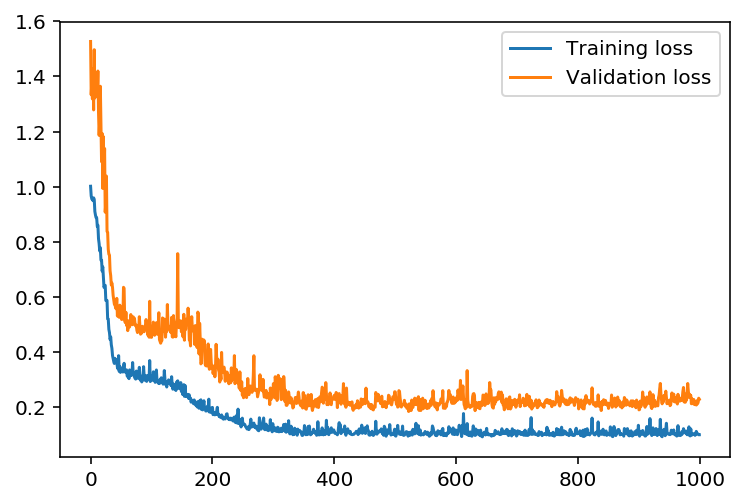

In [46]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim()

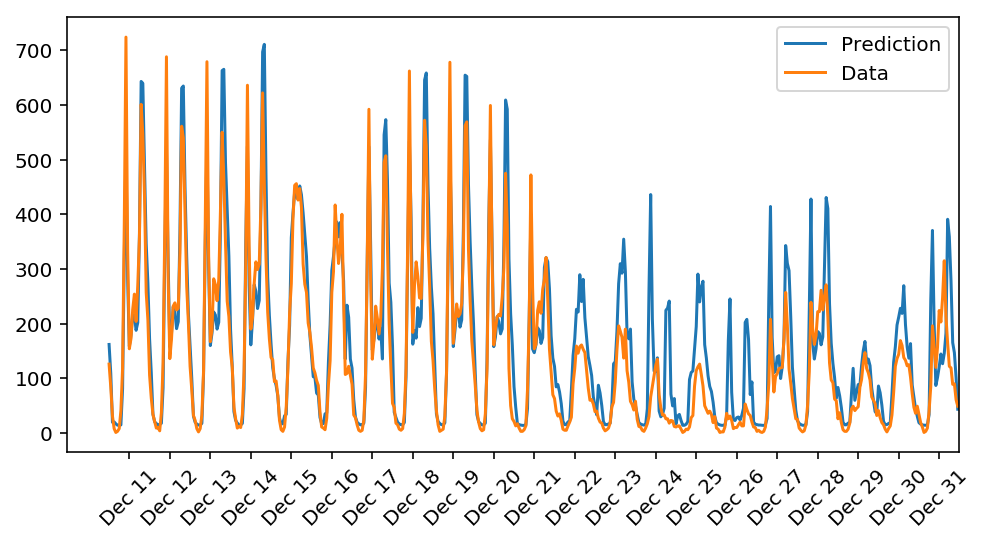

In [51]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean  #（504,1）
ax.plot(predictions, label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data') #（504,)
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)